# Valuation of Housing Developments in SF

### Imports

In [3]:
# Importing Necessary Packages

import pandas as pd
import numpy as np
import urllib.request
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import reverse_geocoder as rg
import pprint
import geocoder
import multiprocessing as mp
import geopy
from geopy.geocoders import Nominatim
from geopy.point import Point
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor

## Table of Contents

### 1. Exploratory Data Analysis and Cleaning
 - ####    a. Valuations Dataset
 - ####    b. Police Dataset
 - ####    c. City Survey Dataset
 - ####    d. Final Dataset Join
 - ####    e. Export Final Dataset 
### 2. Baseline Model (Linear Regression and Median)
 - ####    a. Prep/Split/Preprocessing
 - ####    b. Model Definition/Run Model
### 3. Final Model (Random Forest)
 - ####    a. Prep/Split/Preprocessing
 - ####    b. Model Definition/Run Model
 - ####    c. Model Results

## 1. Exploratory Data Analysis and Cleaning

### 1a. Valuations Dataset

In [2]:
# Read in valuation data
valuation = pd.read_csv("Assessor_Historical_Secured_Property_Tax_Rolls.csv", low_memory=False)

In [3]:
# Drop nan values in geom data
val2 = valuation.dropna(subset = ['the_geom'])
val2.the_geom

95             POINT (-122.367656626348 37.711031780644)
96             POINT (-122.377197630074 37.710780097332)
97             POINT (-122.377457728422 37.711619808594)
98            POINT (-122.36841914661701 37.71112888287)
99           POINT (-122.37510574759702 37.714233963743)
                               ...                      
2666112        POINT (-122.469234215927 37.720116938309)
2666113      POINT (-122.46903919315598 37.711526516997)
2666114         POINT (-122.483524712308 37.70956434276)
2666115        POINT (-122.473845101411 37.734423011387)
2666116    POINT (-122.46321903048002 37.71387055028001)
Name: the_geom, Length: 2663991, dtype: object

In [6]:
#we will get some "settingWithCopyWarnings", surpress those
import warnings
warnings.filterwarnings('ignore')

# Format geom data for our use
val2["x"] = val2["the_geom"].str.split("\s+").str[1].str.replace("\(", "")
val2["y"] = val2["the_geom"].str.split("\s+").str[2].str.rstrip(")")

# Convert extracted values to numeric type
val2["x"] = pd.to_numeric(val2["x"])
val2["y"] = pd.to_numeric(val2["y"])
val2["x"] 

95        -122.367657
96        -122.377198
97        -122.377458
98        -122.368419
99        -122.375106
              ...    
2666112   -122.469234
2666113   -122.469039
2666114   -122.483525
2666115   -122.473845
2666116   -122.463219
Name: x, Length: 2663991, dtype: float64

In [7]:
# Read in Zip GeoDF
data_poly = gpd.read_file("San Francisco ZIP Codes.geojson")

In [9]:
# Convert val2 to GeoDF and join with Zip GeoDF

gdf = gpd.GeoDataFrame(val2, geometry=gpd.points_from_xy(val2.x, val2.y))
joined_gdf = gpd.sjoin(gdf, data_poly, op='within')

In [10]:
# Display Columns in Joined DF
joined_gdf.columns

Index(['Closed Roll Year', 'Property Location', 'Parcel Number', 'Block',
       'Lot', 'Volume Number', 'Use Code', 'Use Definition',
       'Property Class Code', 'Property Class Code Definition',
       'Year Property Built', 'Number of Bathrooms', 'Number of Bedrooms',
       'Number of Rooms', 'Number of Stories', 'Number of Units',
       'Zoning Code', 'Construction Type', 'Lot Depth', 'Lot Frontage',
       'Property Area', 'Basement Area', 'Lot Area', 'Lot Code',
       'Tax Rate Area Code', 'Percent of Ownership', 'Exemption Code',
       'Exemption Code Definition', 'Status Code', 'Misc Exemption Value',
       'Homeowner Exemption Value', 'Current Sales Date',
       'Assessed Fixtures Value', 'Assessed Improvement Value',
       'Assessed Land Value', 'Assessed Personal Property Value',
       'Assessor Neighborhood District', 'Assessor Neighborhood Code',
       'Assessor Neighborhood', 'Supervisor District', 'Analysis Neighborhood',
       'the_geom', 'Row ID', 'SF Find 

In [11]:
# Choose Relevant Columns
val_clean = joined_gdf[["Closed Roll Year", "id", "Assessed Improvement Value", "Assessed Land Value", "Assessed Personal Property Value",
"Year Property Built", "Number of Bathrooms","Number of Bedrooms", "Number of Rooms", "Number of Stories", "Number of Units", "Assessor Neighborhood District", "Assessor Neighborhood Code"]]

In [12]:
# Keep only data from the years 2013 through 2019
val_clean = val_clean[(val_clean["Closed Roll Year"] >= 2013) & (val_clean["Closed Roll Year"] <= 2019)]

# Create Total Assesed Value which equals Assessed Personal Property Value + Assessed Improvement Value
val_clean["Total Assessed Value"] = val_clean["Assessed Land Value"] + val_clean["Assessed Improvement Value"]
val_clean = val_clean.rename(columns = {"id":"Zipcode"})

In [13]:
# Check for invalid zipcodes (none)
val_clean["Zipcode"].value_counts()

94112    134122
94110    107969
94122    104996
94116     97966
94109     85960
94107     77379
94121     71152
94114     70640
94134     68266
94131     66102
94124     64247
94118     64225
94117     58289
94115     51145
94127     50719
94102     47865
94123     45460
94103     41705
94132     41158
94105     36439
94133     31775
94108     19997
94111      9908
94158      9000
94104      1932
94130       276
94129         7
Name: Zipcode, dtype: int64

In [14]:
# Check to look at Total Assessed Value
val_clean["Total Assessed Value"].value_counts()

0          40069
2800       13323
1400        3835
1200        2280
3600        1825
           ...  
1106406        1
686543         1
1255396        1
675958         1
450600         1
Name: Total Assessed Value, Length: 634085, dtype: int64

In [15]:
# Drop the rows where Total Assessed Value = 0
val_clean = val_clean[val_clean["Total Assessed Value"] != 0]
val_clean["Total Assessed Value"].value_counts()

2800       13323
1400        3835
1200        2280
3600        1825
1600        1765
           ...  
1738416        1
486873         1
334067         1
540655         1
450600         1
Name: Total Assessed Value, Length: 634084, dtype: int64

In [16]:
# Take a precursory look at val_clean
val_clean.describe()

,Closed Roll Year,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Assessor Neighborhood District,Total Assessed Value
count,1.418630e+06,1.418630e+06,1.418630e+06,1.418630e+06,1.340181e+06,1.418630e+06,1.418630e+06,1.418625e+06,1.418623e+06,1.418630e+06,1.416307e+06,1.418630e+06
mean,2.016017e+03,5.119169e+05,5.212793e+05,3.895418e+03,1.942454e+03,2.427495e+00,1.262753e+00,7.902100e+00,1.583227e+00,1.844164e+00,6.032745e+00,1.033196e+06
std,1.999531e+00,5.525180e+06,3.026108e+06,2.987875e+05,3.372800e+01,8.477048e+00,1.144086e+01,2.317278e+01,8.541893e+00,1.563507e+01,3.117511e+00,7.936774e+06
min,2.013000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,2.014000e+03,1.123772e+05,8.271325e+04,0.000000e+00,1.914000e+03,1.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,2.242030e+05
50%,2.016000e+03,2.284160e+05,2.663630e+05,0.000000e+00,1.936000e+03,2.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,5.055600e+05
75%,2.018000e+03,3.923980e+05,5.071288e+05,0.000000e+00,1.963000e+03,2.000000e+00,2.000000e+00,8.000000e+00,2.000000e+00,1.000000e+00,9.000000e+00,8.965658e+05
max,2.019000e+03,1.750000e+09,6.071487e+08,1.401327e+08,2.020000e+03,1.002000e+03,3.800000e+03,3.606000e+03,9.990000e+02,4.000000e+03,1.000000e+01,1.822089e+09


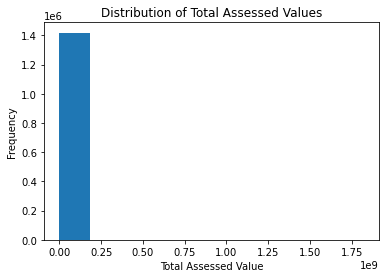

In [18]:
# Take a look at Distribution of Total Assessed Values, 
#We can see that there is long right tail due to a few expensive lots, we will instead look at the log distribution
plt.hist(val_clean['Total Assessed Value'], bins=10)
plt.xlabel('Total Assessed Value')
plt.ylabel('Frequency')
plt.title('Distribution of Total Assessed Values')
plt.show()

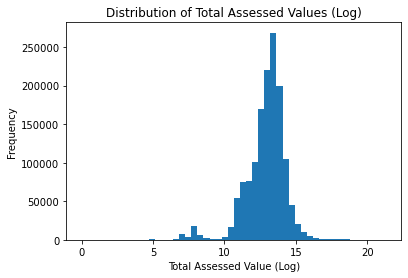

In [19]:
# Take a look at Distribution of Log Total Assessed Values, somewhat normally distributed
#definite improvement over the dist of untransformed values
plt.hist(np.log(val_clean['Total Assessed Value']), bins=50)
plt.xlabel('Total Assessed Value (Log)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Assessed Values (Log)')
plt.show()

In [20]:
#Add log(total assessed values) to table
val_clean['Total Assessed Log Value'] = np.log(val_clean['Total Assessed Value'])

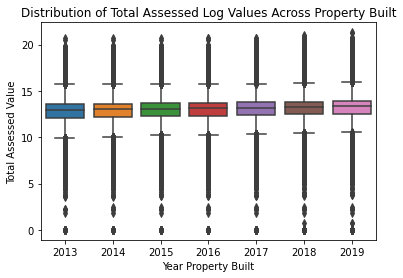

In [21]:
# Take a look at how year built may affect Total Assessed Log Value (2013-2019), we see the median looks fairly stable across time

sns.boxplot(x='Closed Roll Year', y='Total Assessed Log Value', data=val_clean)
plt.xlabel('Year Property Built')
plt.ylabel('Total Assessed Value')
plt.title('Distribution of Total Assessed Log Values Across Property Built')
plt.show()

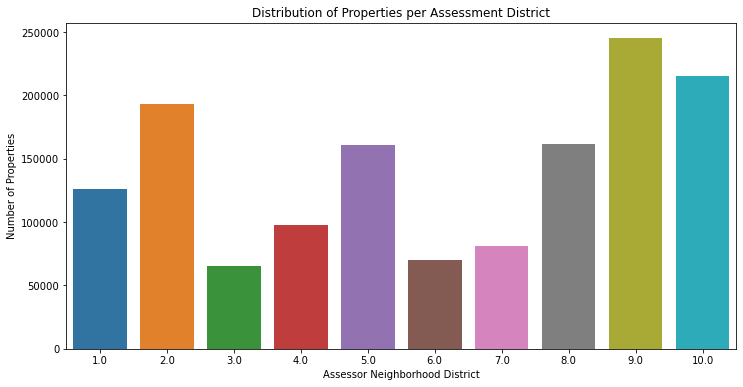

In [22]:
# Take a look at how many properties are in each assessment district
plt.figure(figsize=(12,6))
sns.countplot(x='Assessor Neighborhood District', data=val_clean)
plt.xlabel('Assessor Neighborhood District')
plt.ylabel('Number of Properties')
plt.title('Distribution of Properties per Assessment District')
plt.show()

In [23]:
# Mapping property values by zip code, blacked out area is Presidio (not for sale properties, government owned)
map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
choropleth = folium.Choropleth(geo_data='San Francisco ZIP Codes.geojson', name='choropleth', data=val_clean, columns=['Zipcode', 'Total Assessed Log Value'], key_on='feature.properties.id', fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2, legend_name='Total Assessed Value').add_to(map_sf)
folium.LayerControl().add_to(map_sf)
map_sf

### 1b. Police Dataset

In [24]:
# Read in SFPD Crime Datasets

police_df1318 = pd.read_csv("PoliceDepartment_IncidentReports_2003_May2018.csv")
police_df_18 = pd.read_csv("Police_Department_Incident_Reports__2018_to_Present.csv")

In [25]:
# Create geometry columns in order to extract zipcode later
police_df_18['geometry'] = police_df_18['Point']
police_df1318['geometry'] = police_df1318['location']

In [26]:
# Drop unneeded columns
police_df13 = police_df1318.drop(columns=['DELETE - 2017 Fix It Zones 2 2', 'Civic Center Harm Reduction Project Boundary 2 2',
          'Fix It Zones as of 2017-11-06  2 2', 'DELETE - HSOC Zones 2 2', "location",
          'Fix It Zones as of 2018-02-07 2 2', 'CBD, BID and GBD Boundaries as of 2017 2 2', 
          'Central Market/Tenderloin Boundary 2 2', 'Central Market/Tenderloin Boundary Polygon - Updated 2 2',
          'HSOC Zones as of 2018-06-05 2 2', 'OWED Public Spaces 2 2', 'DELETE - Fire Prevention Districts 2 2','DELETE - Police Districts 2 2',
          'DELETE - Supervisor Districts 2 2','DELETE - Zip Codes 2 2','DELETE - Neighborhoods 2 2',
          'SF Find Neighborhoods 2 2', 'Current Police Districts 2 2','Time',
          'Current Supervisor Districts 2 2','Analysis Neighborhoods 2 2', 'DayOfWeek', 'Resolution',
          'Areas of Vulnerability, 2016 2 2','Neighborhoods 2', 'Incident Code', 'Descript'])

police_df18 = police_df_18.drop(columns=['Report Datetime', 'Row ID','Incident Subcategory', 'Incident Description',
        'Resolution', 'Intersection', 'CNN', 
        'Analysis Neighborhood', 'Supervisor District','Point',
        'Supervisor District 2012', 'CAD Number',
        'Report Type Code', 'Report Type Description', 'Filed Online',
        'Incident Code',
        'Neighborhoods', 'ESNCAG - Boundary File',
        'Central Market/Tenderloin Boundary Polygon - Updated','Incident Day of Week', 
        'Civic Center Harm Reduction Project Boundary', 'Incident Date', 'Incident Time', 'Incident Year',
        'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas',
        'Current Supervisor Districts', 'Current Police Districts'])

In [27]:
# Format 2018-Present to prepare for combining the two separate sets.
police_df18 = police_df18.rename(columns = {'Incident ID':'PdId', 'Incident Number': 'IncidntNum', 'Longitude':'X', 'Latitude':'Y',
                                           'Incident Datetime':'Date', 'Police District':'PdDistrict', 'Incident Category': 'Category',
                                           'geometry':'geometry'})

# Placeholder for address for 2018-present data
police_df18['Address'] = 0

In [28]:
# Double-check whether columns are the same across 2013-2018 & 2018-Present dataset
police_df13.columns, police_df18.columns #True

(Index(['PdId', 'IncidntNum', 'Category', 'Date', 'PdDistrict', 'Address', 'X',
        'Y', 'geometry'],
       dtype='object'),
 Index(['Date', 'PdId', 'IncidntNum', 'Category', 'PdDistrict', 'Y', 'X',
        'geometry', 'Address'],
       dtype='object'))

In [29]:
# Append dataframes
police_df18 = police_df18[['PdId', 'IncidntNum', 'Category', 'Date', 'PdDistrict', 'Address','X', 'Y', 'geometry']]
police_df13.columns == police_df18.columns
police = pd.concat([police_df18, police_df13])

In [30]:
# Filter out overlap for 2018 & any other duplicates
police = police.drop_duplicates()

#check if any duplicates remain --> none left
police.duplicated().unique()

array([False])

In [31]:
# Convert Date column to datetime
police['Incident Date'] = pd.to_datetime(police['Date'])
police['Year'] = police['Incident Date'].dt.year # create a new Year column
police

,PdId,IncidntNum,Category,Date,PdDistrict,Address,X,Y,geometry,Incident Date,Year
0,1253736,230167874,Recovered Vehicle,2023/03/13 11:41:00 PM,Out of SF,0,NaN,NaN,NaN,2023-03-13 23:41:00,2023
1,1253795,236046151,Larceny Theft,2023/03/01 05:02:00 AM,Mission,0,NaN,NaN,NaN,2023-03-01 05:02:00,2023
2,1253571,220343896,Recovered Vehicle,2023/03/13 01:16:00 PM,Out of SF,0,NaN,NaN,NaN,2023-03-13 13:16:00,2023
3,1253551,230174885,Recovered Vehicle,2023/03/13 10:59:00 AM,Out of SF,0,NaN,NaN,NaN,2023-03-13 10:59:00,2023
4,1254024,230176728,Recovered Vehicle,2023/03/14 06:44:00 PM,Out of SF,0,NaN,NaN,NaN,2023-03-14 18:44:00,2023
...,...,...,...,...,...,...,...,...,...,...,...
2129520,17050730416710,170507304,DRUG/NARCOTIC,06/22/2017,CENTRAL,BROADWAY ST / DAVIS ST,-122.398699,37.798880,POINT (-122.39869911640743 37.798880026259866),2017-06-22 00:00:00,2017
2129521,17071435504014,170714355,ASSAULT,09/01/2017,PARK,HAIGHT ST / BUENAVISTAWEST AV,-122.443312,37.770470,POINT (-122.44331194960198 37.77046975485389),2017-09-01 00:00:00,2017
2129522,17053348465010,170533484,OTHER OFFENSES,06/30/2017,BAYVIEW,ILLINOIS ST / 23RD ST,-122.387068,37.755446,POINT (-122.38706797754722 37.75544602661817),2017-06-30 00:00:00,2017
2129523,17102776330130,171027763,OTHER OFFENSES,12/20/2017,SOUTHERN,7TH ST / MARKET ST,-122.412515,37.780478,POINT (-122.41251534135559 37.78047774805081),2017-12-20 00:00:00,2017


In [32]:
# Filter for years 2013-2019
police_filtered = police.loc[police['Year'] <= 2019]
police_filtered = police_filtered.loc[police_filtered['Year'] >= 2013]
police_filtered

,PdId,IncidntNum,Category,Date,PdDistrict,Address,X,Y,geometry,Incident Date,Year
35,730062,186245900,Lost Property,2018/09/03 09:00:00 AM,Out of SF,0,NaN,NaN,NaN,2018-09-03 09:00:00,2018
36,759820,196009821,Lost Property,2019/01/13 02:00:00 PM,Out of SF,0,NaN,NaN,NaN,2019-01-13 14:00:00,2019
37,733761,180833020,Lost Property,2018/11/02 12:00:00 PM,Taraval,0,NaN,NaN,NaN,2018-11-02 12:00:00,2018
39,831413,190574333,Assault,2019/08/06 02:25:00 PM,Central,0,NaN,NaN,NaN,2019-08-06 14:25:00,2019
41,634323,186033620,Lost Property,2018/01/18 04:00:00 PM,Tenderloin,0,NaN,NaN,NaN,2018-01-18 16:00:00,2018
...,...,...,...,...,...,...,...,...,...,...,...
2129520,17050730416710,170507304,DRUG/NARCOTIC,06/22/2017,CENTRAL,BROADWAY ST / DAVIS ST,-122.398699,37.798880,POINT (-122.39869911640743 37.798880026259866),2017-06-22 00:00:00,2017
2129521,17071435504014,170714355,ASSAULT,09/01/2017,PARK,HAIGHT ST / BUENAVISTAWEST AV,-122.443312,37.770470,POINT (-122.44331194960198 37.77046975485389),2017-09-01 00:00:00,2017
2129522,17053348465010,170533484,OTHER OFFENSES,06/30/2017,BAYVIEW,ILLINOIS ST / 23RD ST,-122.387068,37.755446,POINT (-122.38706797754722 37.75544602661817),2017-06-30 00:00:00,2017
2129523,17102776330130,171027763,OTHER OFFENSES,12/20/2017,SOUTHERN,7TH ST / MARKET ST,-122.412515,37.780478,POINT (-122.41251534135559 37.78047774805081),2017-12-20 00:00:00,2017


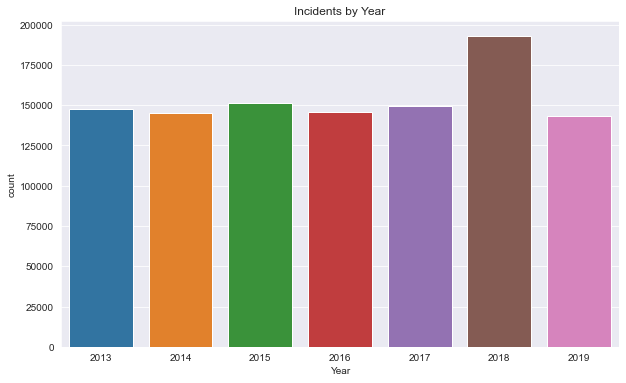

In [33]:
# Take a look at number of incidents per year

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', data=police_filtered)
plt.title('Incidents by Year')
plt.show()

In [34]:
# Drop all missing coordinate values
police_filtered = police_filtered.dropna(subset=['X','Y'], how='all')
police_filtered.head()

,PdId,IncidntNum,Category,Date,PdDistrict,Address,X,Y,geometry,Incident Date,Year
309,1037700,210348157,Rape,2019/06/11 04:30:00 PM,Southern,0,-122.408846,37.775953,POINT (-122.40884575063417 37.775953228502786),2019-06-11 16:30:00,2019
1226,1135366,220204947,Courtesy Report,2019/06/01 12:00:00 AM,Out of SF,0,-122.391434,37.773467,POINT (-122.39143433652146 37.773466920607476),2019-06-01 00:00:00,2019
3071,1258117,236054370,Lost Property,2019/04/01 12:00:00 AM,Ingleside,0,-122.415291,37.713504,POINT (-122.41529083617453 37.71350427378473),2019-04-01 00:00:00,2019
3191,1258144,230206632,Fraud,2019/12/01 12:00:00 AM,Southern,0,-122.390527,37.780607,POINT (-122.39052723477022 37.78060675630406),2019-12-01 00:00:00,2019
4125,1259824,236024323,Larceny Theft,2019/02/06 06:00:00 PM,Tenderloin,0,-122.416401,37.777723,POINT (-122.41640107183976 37.777722750028566),2019-02-06 18:00:00,2019


In [35]:
#Begin converting lat/long values to associated zipcodes

#load in the geoJSON file with zipcode boundaries first
data_poly = gpd.read_file("San Francisco ZIP Codes.geojson")

In [36]:
# Create Police GeoDF and join with Zip Code GDF
#Thhis assigns a zipcode to each of the lat/long points in each row
gdf = gpd.GeoDataFrame(police_filtered, geometry=gpd.points_from_xy(police_filtered.X, police_filtered.Y))
joined_gdf = gpd.sjoin(gdf, data_poly, op='within')

In [37]:
# Take a look at the count of instances per zip code
joined_gdf['id'].value_counts()

94103    162104
94102    111369
94110     99057
94109     80986
94124     58493
94107     51237
94112     46098
94133     45430
94115     41872
94117     41092
94114     36408
94122     31495
94108     29770
94118     28595
94134     27009
94123     25576
94105     23778
94121     21358
94132     21341
94111     20677
94116     17880
94131     14970
94127      8716
94104      5856
94158      5494
94130      2242
94129       316
Name: id, dtype: int64

In [38]:
# Choose relevant columns and get info
police_final = joined_gdf[['PdId', 'IncidntNum', 'Category', 'Date', 'Year', 'id']].rename(columns = {'id': 'zipcode'})
police_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059219 entries, 309 to 2129372
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   PdId        1059219 non-null  int64 
 1   IncidntNum  1059219 non-null  int64 
 2   Category    1059207 non-null  object
 3   Date        1059219 non-null  object
 4   Year        1059219 non-null  int64 
 5   zipcode     1059219 non-null  object
dtypes: int64(3), object(3)
memory usage: 56.6+ MB


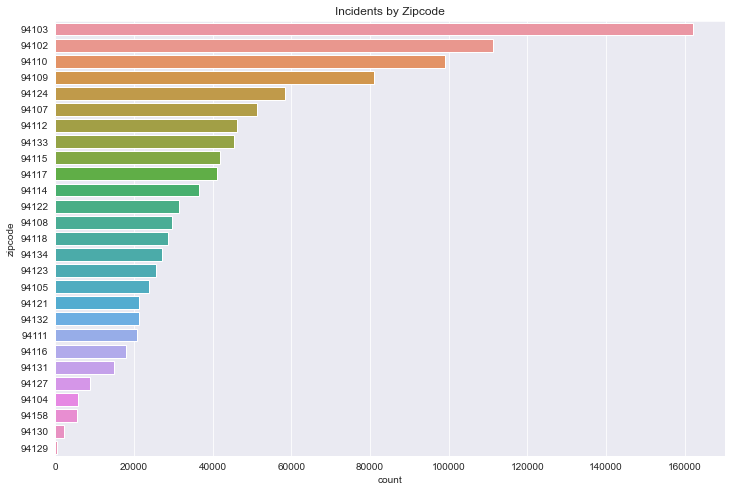

In [39]:
# Take a look at number of incidents by Zipcode

plt.figure(figsize=(12, 8))
sns.countplot(y='zipcode', data=police_final, order=police_final['zipcode'].value_counts().index)
plt.title('Incidents by Zipcode')
plt.show()

### 1c. City Survey Dataset

In [40]:
# Read in City Survey data
xls = pd.ExcelFile('City Survey Master Data 1996-2019.xlsx')
city_df = pd.read_excel(xls, 'Historical Data')

In [47]:
#we will get a SettingWithCopyWarning for the aggregation below -- surpress that
warnings.filterwarnings('ignore')

# Isolate columns of interest
columns = [ "year", "dem_zip", "dem_district", "inf_clean", "inf_stcond", "inf_sidecond", "inf_clean_side", "inf_clean_st", "safe_day", "safe_night", "dem_hhsize"]
dfagg = city_df[columns]

# Isolate columns for cleanliness & exclude missing values/columns with ratings of 6 or 7
relevant_columns = ["inf_clean", "inf_stcond", "inf_sidecond", "inf_clean_side", "inf_clean_st"]
rating_map = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
}
dfagg[relevant_columns] = dfagg[relevant_columns].replace(rating_map)

# Convert the ratings to numeric values and replace non-integer values with NaN
dfagg[relevant_columns] = dfagg[relevant_columns].applymap(lambda x: pd.to_numeric(x, errors='coerce'))

# Compute the mean for each row, excluding NaN values
dfagg['cleanliness'] = dfagg[relevant_columns].mean(axis=1, skipna=True)

# Print the result
dfagg['cleanliness'].value_counts()

4.000000    5615
3.000000    5083
3.666667    2594
3.333333    2474
2.000000    2163
2.666667    1885
2.333333    1389
5.000000    1299
3.500000    1233
4.333333    1051
1.000000     906
2.500000     871
4.666667     794
1.666667     647
3.750000     438
3.250000     387
1.333333     362
4.500000     356
2.750000     356
4.250000     256
1.500000     223
2.250000     209
4.750000     147
1.750000      91
1.250000      33
Name: cleanliness, dtype: int64

In [48]:
# Create a cleaned df for 2019
dfagg = dfagg.drop(relevant_columns, axis=1)
df2019_cleaned = dfagg.rename(columns={"dem_zip":"zipcode", "dem_district": "district","dem_hhsize":"household_size"})
df2019_cleaned

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
0,2019,94112.0,11.0,4.0,2.0,6.0,3.333333
1,2019,99999.0,4.0,4.0,2.0,1.0,4.000000
2,2019,99999.0,NaN,5.0,2.0,2.0,3.666667
3,2019,99999.0,4.0,4.0,3.0,6.0,3.000000
4,2019,94132.0,7.0,4.0,3.0,3.0,5.000000
...,...,...,...,...,...,...,...
40185,1996,94116.0,NaN,3.0,3.0,3.0,NaN
40186,1996,94134.0,NaN,4.0,3.0,3.0,NaN
40187,1996,94112.0,NaN,4.0,4.0,4.0,NaN
40188,1996,94118.0,NaN,1.0,1.0,5.0,NaN


In [49]:
# Find entries without/invalid zipcodes & replace with 0
df2019_cleaned['zipcode'] = df2019_cleaned['zipcode'].fillna(0).astype(int)
df2019_cleaned['zipcode'] = df2019_cleaned['zipcode'].replace([88888, 99999], 0)

In [50]:
# Filter for years 2013-2019
survey_filtered = df2019_cleaned.loc[df2019_cleaned['year'] <= 2019]
survey_filtered = survey_filtered.loc[df2019_cleaned['year'] >= 2013]
survey_filtered

# Notes: No zipcodes available for 2015, Only have data every other year starting 2005

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
0,2019,94112,11.0,4.0,2.0,6.0,3.333333
1,2019,0,4.0,4.0,2.0,1.0,4.000000
2,2019,0,NaN,5.0,2.0,2.0,3.666667
3,2019,0,4.0,4.0,3.0,6.0,3.000000
4,2019,94132,7.0,4.0,3.0,3.0,5.000000
...,...,...,...,...,...,...,...
10186,2013,94126,9.0,NaN,NaN,NaN,NaN
10187,2013,94126,9.0,4.0,4.0,5.0,2.250000
10188,2013,94126,10.0,3.0,2.0,NaN,3.000000
10189,2013,94126,10.0,4.0,3.0,NaN,3.250000


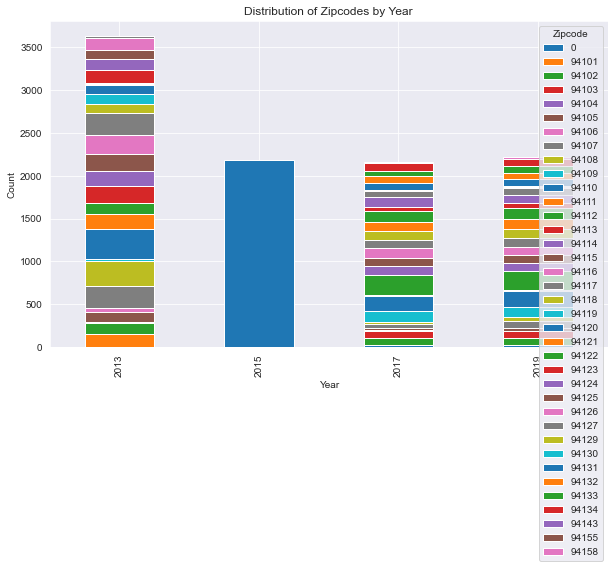

In [51]:
# Group the data by year and zipcode and count the occurrences
grouped = survey_filtered.groupby(['year', 'zipcode']).size().unstack()

# Plot occurences by year and zipcode
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Year') 
ax.set_ylabel('Count')
ax.legend(title='Zipcode', loc='upper right')
ax.set_title('Distribution of Zipcodes by Year')
plt.show()

***Zipcode 0 indicates no zipcode was collected for that survey response. We can see here that 2015 does not have any zipcode data***

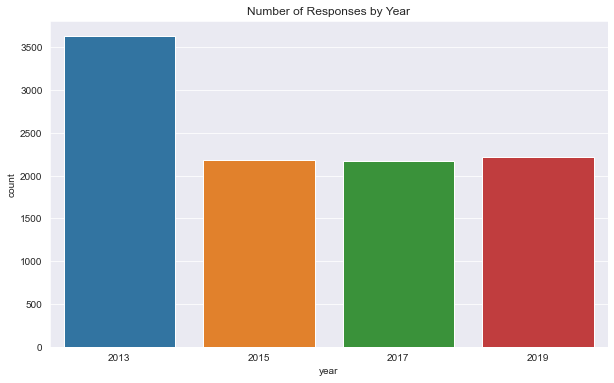

In [52]:
# Take a look at count of responses by year
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='year', data=survey_filtered)
plt.title('Number of Responses by Year')
plt.show()

In [53]:
# 2015 has no zipcode data
survey_filtered[survey_filtered['year'] == 2015]

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
4384,2015,0,8.0,NaN,NaN,1.0,4.00
4385,2015,0,2.0,5.0,3.0,1.0,NaN
4386,2015,0,5.0,5.0,NaN,1.0,NaN
4387,2015,0,7.0,5.0,5.0,2.0,NaN
4388,2015,0,6.0,NaN,NaN,1.0,3.25
...,...,...,...,...,...,...,...
6558,2015,0,12.0,NaN,NaN,3.0,3.25
6559,2015,0,1.0,5.0,5.0,1.0,NaN
6560,2015,0,8.0,NaN,NaN,2.0,4.00
6561,2015,0,9.0,5.0,5.0,3.0,NaN


In [54]:
#Unable to identify correct zipcode for zipcode value 0 (missing data) by district since there are multiple zipcodes per district
survey_filtered.groupby(['district', 'zipcode']).count()

year  safe_day  safe_night  household_size  cleanliness
district zipcode                                                         
1.0      0         151        75          73             151           77
         94104       1         1           1               1            0
         94105       1         1           1               1            1
         94109       1         1           1               1            1
         94114       5         5           5               5            5
...                ...       ...         ...             ...          ...
11.0     94127       9         9           8               9            8
         94131       1         0           0               1            1
         94132      31        21          20              31           21
         94134      20        20          20              20           15
12.0     0          81        44          41              81           35

[216 rows x 5 columns]

In [55]:
# Fill in gap years with previous year data (i.e. fill in 2014 & 2015 & 2016 data with 2013 data)
#we will get a SettingWithCopyWarning for the aggregation below -- surpress that
warnings.filterwarnings('ignore')

# Drop 2015 data without zipcodes
survey_filtered1 = survey_filtered[survey_filtered.zipcode != 0]
survey_filtered1.year.value_counts()

# Want 2013-2019

# Create 2014, 2015, 2016 data with 2013 data
df2014 = survey_filtered1[survey_filtered1.year == 2013]
df2014['year'] = df2014['year'].replace(2013, 2014)
df2015 = survey_filtered1[survey_filtered1.year == 2013]
df2015['year'] = df2015['year'].replace(2013, 2015)
df2016 = survey_filtered1[survey_filtered1.year == 2013]
df2016['year'] = df2016['year'].replace(2013, 2016)

# Create 2018 data with 2017 data
df2018 = survey_filtered1[survey_filtered1.year == 2017]
df2018['year'] = df2018['year'].replace(2017, 2018)

# Append all dataframes back to original df --> survey_filtered
survey_final = pd.concat([survey_filtered1, df2014, df2015, df2016, df2018])
survey_final

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
0,2019,94112,11.0,4.0,2.0,6.0,3.333333
4,2019,94132,7.0,4.0,3.0,3.0,5.000000
5,2019,94134,10.0,4.0,1.0,0.0,1.666667
6,2019,94117,6.0,5.0,5.0,2.0,3.000000
7,2019,94122,3.0,4.0,4.0,3.0,3.000000
...,...,...,...,...,...,...,...
4379,2018,94115,5.0,NaN,NaN,2.0,4.333333
4380,2018,94115,2.0,NaN,NaN,2.0,NaN
4381,2018,94134,10.0,NaN,NaN,4.0,NaN
4382,2018,94110,9.0,5.0,4.0,3.0,NaN


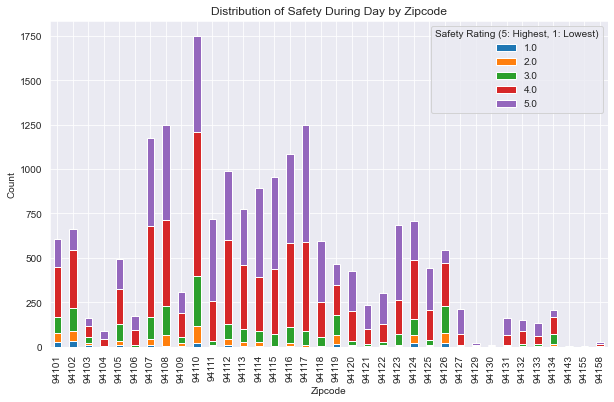

In [57]:
# Group the data by zip and day
grouped = survey_final.groupby(['zipcode', 'safe_day']).size().unstack()

# Plot a stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Zipcode') 
ax.set_ylabel('Count')
ax.legend(title='Safety Rating (5: Highest, 1: Lowest)', loc='upper right')
ax.set_title('Distribution of Safety During Day by Zipcode')
plt.show()

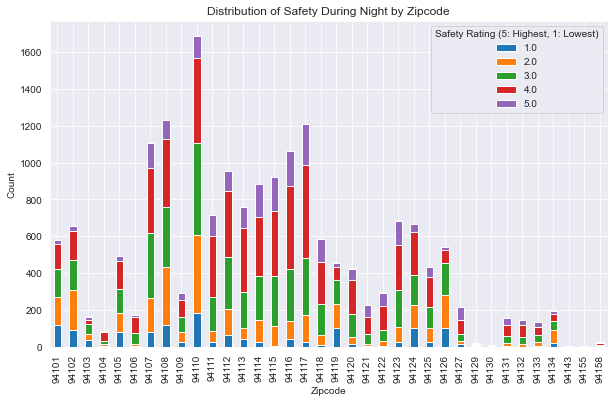

In [58]:
# Group the data by zip and night
grouped = survey_final.groupby(['zipcode', 'safe_night']).size().unstack()

# Plot a stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Zipcode') 
ax.set_ylabel('Count')
ax.legend(title='Safety Rating (5: Highest, 1: Lowest)', loc='upper right')
ax.set_title('Distribution of Safety During Night by Zipcode')
plt.show()

### 1d. Final Dataset (Merging Housing_value, Police, and Survey Datasets)

In [59]:
# Final dataframes for Years 2013-2019 (will join with valuation data)
display(survey_final)
display(police_final)

,year,zipcode,district,safe_day,safe_night,household_size,cleanliness
0,2019,94112,11.0,4.0,2.0,6.0,3.333333
4,2019,94132,7.0,4.0,3.0,3.0,5.000000
5,2019,94134,10.0,4.0,1.0,0.0,1.666667
6,2019,94117,6.0,5.0,5.0,2.0,3.000000
7,2019,94122,3.0,4.0,4.0,3.0,3.000000
...,...,...,...,...,...,...,...
4379,2018,94115,5.0,NaN,NaN,2.0,4.333333
4380,2018,94115,2.0,NaN,NaN,2.0,NaN
4381,2018,94134,10.0,NaN,NaN,4.0,NaN
4382,2018,94110,9.0,5.0,4.0,3.0,NaN


,PdId,IncidntNum,Category,Date,Year,zipcode
309,1037700,210348157,Rape,2019/06/11 04:30:00 PM,2019,94103
9854,670158,180373979,Assault,2018/05/18 03:57:00 PM,2018,94103
9942,654748,180260514,Arson,2018/04/08 11:25:00 PM,2018,94103
10648,818145,190478644,Warrant,2019/07/02 01:35:00 PM,2019,94103
11494,870625,190866124,Assault,2019/11/15 04:40:00 PM,2019,94103
...,...,...,...,...,...,...
2128576,17026429772000,170264297,NON-CRIMINAL,03/31/2017,2017,94104
2128672,17620189306314,176201893,LARCENY/THEFT,08/02/2017,2017,94104
2128752,17038714064020,170387140,NON-CRIMINAL,05/11/2017,2017,94104
2128987,17060849109320,170608491,FRAUD,07/25/2017,2017,94104


In [60]:
# Format valuation data in order to join
val_final = val_clean.rename(columns = {'Closed Roll Year': 'Year'})
val_final.head()

,Year,Zipcode,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Assessor Neighborhood District,Assessor Neighborhood Code,Total Assessed Value,Total Assessed Log Value
174033,2016,94121,181379,181379,0,1980.0,1.0,1,3.0,1.0,1,1.0,1E,362758,12.801491
208896,2016,94121,401392,577844,0,1914.0,6.0,9,21.0,3.0,6,1.0,1D,979236,13.794528
208897,2016,94121,259562,389342,0,1925.0,2.0,4,8.0,1.0,1,1.0,1E,648904,13.383040
210872,2016,94121,294460,441694,0,1911.0,1.0,3,6.0,2.0,1,1.0,1E,736154,13.509195
211974,2016,94121,488640,1140160,0,1900.0,2.0,0,6.0,2.0,1,1.0,1A,1628800,14.303354


In [61]:
# Get the count of incidents from police_final 
police_final2 = police_final.groupby(['Year','zipcode']).count().reset_index().rename(columns = {'PdId':'Incident Counts', 'zipcode':'Zipcode'})
police_final2 = police_final2.drop(columns = ['IncidntNum','Date', 'Category'])
police_final2

,Year,Zipcode,Incident Counts
0,2013,94102,17610
1,2013,94103,24390
2,2013,94104,675
3,2013,94105,2881
4,2013,94107,6867
...,...,...,...
180,2019,94131,2209
181,2019,94132,2900
182,2019,94133,6434
183,2019,94134,3545


In [62]:
# Get average of safe_day,safe_night,household_size,cleanliness for each year,zipcode pair
survey_final2 = survey_final.groupby(['year','zipcode']).mean().reset_index().drop(columns = ['district']).rename(columns = {'year': 'Year', 'zipcode':'Zipcode'})
survey_final2

,Year,Zipcode,safe_day,safe_night,household_size,cleanliness
0,2013,94101,3.814570,2.641379,1.753425,3.127222
1,2013,94102,3.696721,2.680328,2.121951,2.958333
2,2013,94103,5.000000,3.000000,1.000000,3.500000
3,2013,94104,4.611111,3.611111,1.611111,3.375000
4,2013,94105,3.963636,2.818182,1.981818,3.295045
...,...,...,...,...,...,...
196,2019,94133,4.202703,3.297297,2.554054,2.972973
197,2019,94134,3.865169,2.865854,3.351648,3.157509
198,2019,94143,3.000000,1.000000,5.000000,1.333333
199,2019,94155,3.000000,3.000000,3.000000,3.000000


In [63]:
# Check datatypes
#val_final.info(), police_final2.info(), survey_final2.info()

# Convert police_final2, val_final Zipcode column from str-->int
police_final2['Zipcode'] = police_final2.Zipcode.astype(int)
val_final['Zipcode'] = val_final.Zipcode.astype(int)

police_final2

val_final.info(), police_final2.info(), survey_final2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1418630 entries, 174033 to 2665834
Data columns (total 15 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Year                              1418630 non-null  int64  
 1   Zipcode                           1418630 non-null  int64  
 2   Assessed Improvement Value        1418630 non-null  int64  
 3   Assessed Land Value               1418630 non-null  int64  
 4   Assessed Personal Property Value  1418630 non-null  int64  
 5   Year Property Built               1340181 non-null  float64
 6   Number of Bathrooms               1418630 non-null  float64
 7   Number of Bedrooms                1418630 non-null  int64  
 8   Number of Rooms                   1418625 non-null  float64
 9   Number of Stories                 1418623 non-null  float64
 10  Number of Units                   1418630 non-null  int64  
 11  Assessor Neighborhood District  

(None, None, None)

In [64]:
# Left join on val_final with police_final2
join1 = pd.merge(val_final, police_final2, on = ['Year', 'Zipcode'], how = 'left')
join1

,Year,Zipcode,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Assessor Neighborhood District,Assessor Neighborhood Code,Total Assessed Value,Total Assessed Log Value,Incident Counts
0,2016,94121,181379,181379,0,1980.0,1.0,1,3.0,1.0,1,1.0,1E,362758,12.801491,3109
1,2016,94121,401392,577844,0,1914.0,6.0,9,21.0,3.0,6,1.0,1D,979236,13.794528,3109
2,2016,94121,259562,389342,0,1925.0,2.0,4,8.0,1.0,1,1.0,1E,648904,13.383040,3109
3,2016,94121,294460,441694,0,1911.0,1.0,3,6.0,2.0,1,1.0,1E,736154,13.509195,3109
4,2016,94121,488640,1140160,0,1900.0,2.0,0,6.0,2.0,1,1.0,1A,1628800,14.303354,3109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418625,2019,94134,220700,220700,0,1994.0,2.0,2,5.0,1.0,1,10.0,10B,441400,12.997707,3545
1418626,2019,94134,258092,258092,0,1990.0,2.0,2,4.0,1.0,1,10.0,10B,516184,13.154219,3545
1418627,2019,94134,134700,94328,0,1987.0,2.0,3,6.0,0.0,1,10.0,10B,229028,12.341600,3545
1418628,2019,94134,198114,198114,0,1987.0,2.0,3,6.0,0.0,1,10.0,10B,396228,12.889745,3545


In [65]:
# Drop nan values
join1 = join1.dropna(subset = ['Year Property Built'])
join1

,Year,Zipcode,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Assessor Neighborhood District,Assessor Neighborhood Code,Total Assessed Value,Total Assessed Log Value,Incident Counts
0,2016,94121,181379,181379,0,1980.0,1.0,1,3.0,1.0,1,1.0,1E,362758,12.801491,3109
1,2016,94121,401392,577844,0,1914.0,6.0,9,21.0,3.0,6,1.0,1D,979236,13.794528,3109
2,2016,94121,259562,389342,0,1925.0,2.0,4,8.0,1.0,1,1.0,1E,648904,13.383040,3109
3,2016,94121,294460,441694,0,1911.0,1.0,3,6.0,2.0,1,1.0,1E,736154,13.509195,3109
4,2016,94121,488640,1140160,0,1900.0,2.0,0,6.0,2.0,1,1.0,1A,1628800,14.303354,3109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418624,2019,94134,225124,225124,0,1994.0,2.0,2,5.0,1.0,1,10.0,10B,450248,13.017554,3545
1418625,2019,94134,220700,220700,0,1994.0,2.0,2,5.0,1.0,1,10.0,10B,441400,12.997707,3545
1418626,2019,94134,258092,258092,0,1990.0,2.0,2,4.0,1.0,1,10.0,10B,516184,13.154219,3545
1418627,2019,94134,134700,94328,0,1987.0,2.0,3,6.0,0.0,1,10.0,10B,229028,12.341600,3545


In [66]:
# Left join join1 with survey_final2
final_df = pd.merge(join1, survey_final2, on = ['Year', 'Zipcode'], how = 'inner')

In [67]:
# Correlation of Total Assessed Value with other features
print(final_df.corr().loc['Total Assessed Value'])

# Drop Assessed Improvement Value & Assessed Land Value since both were used to calculate to Total Assessed Value
final_df = final_df.drop(columns = ['Assessed Improvement Value', 'Assessed Land Value'])

# Final Dataframe
final_df

Year                                0.018823
Zipcode                            -0.040706
Assessed Improvement Value          0.962611
Assessed Land Value                 0.869932
Assessed Personal Property Value    0.130158
Year Property Built                 0.025932
Number of Bathrooms                 0.192179
Number of Bedrooms                  0.018023
Number of Rooms                     0.194781
Number of Stories                   0.069985
Number of Units                     0.177626
Assessor Neighborhood District      0.032441
Total Assessed Value                1.000000
Total Assessed Log Value            0.270051
Incident Counts                     0.007271
safe_day                           -0.012407
safe_night                         -0.017363
household_size                     -0.032059
cleanliness                        -0.032978
Name: Total Assessed Value, dtype: float64


,Year,Zipcode,Assessed Personal Property Value,Year Property Built,Number of Bathrooms,Number of Bedrooms,Number of Rooms,Number of Stories,Number of Units,Assessor Neighborhood District,Assessor Neighborhood Code,Total Assessed Value,Total Assessed Log Value,Incident Counts,safe_day,safe_night,household_size,cleanliness
0,2016,94121,0,1980.0,1.0,1,3.0,1.0,1,1.0,1E,362758,12.801491,3109,4.571429,4.333333,3.428571,3.750000
1,2016,94121,0,1914.0,6.0,9,21.0,3.0,6,1.0,1D,979236,13.794528,3109,4.571429,4.333333,3.428571,3.750000
2,2016,94121,0,1925.0,2.0,4,8.0,1.0,1,1.0,1E,648904,13.383040,3109,4.571429,4.333333,3.428571,3.750000
3,2016,94121,0,1911.0,1.0,3,6.0,2.0,1,1.0,1E,736154,13.509195,3109,4.571429,4.333333,3.428571,3.750000
4,2016,94121,0,1900.0,2.0,0,6.0,2.0,1,1.0,1A,1628800,14.303354,3109,4.571429,4.333333,3.428571,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224077,2019,94134,0,1994.0,2.0,2,5.0,1.0,1,10.0,10B,450248,13.017554,3545,3.865169,2.865854,3.351648,3.157509
1224078,2019,94134,0,1994.0,2.0,2,5.0,1.0,1,10.0,10B,441400,12.997707,3545,3.865169,2.865854,3.351648,3.157509
1224079,2019,94134,0,1990.0,2.0,2,4.0,1.0,1,10.0,10B,516184,13.154219,3545,3.865169,2.865854,3.351648,3.157509
1224080,2019,94134,0,1987.0,2.0,3,6.0,0.0,1,10.0,10B,229028,12.341600,3545,3.865169,2.865854,3.351648,3.157509


In [68]:
# One hot encode zipcode
df_encoded = pd.get_dummies(final_df, columns = ['Zipcode'], drop_first = True) #avoid multicollinearity
df_encoded.columns

Index(['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units',
       'Assessor Neighborhood District', 'Assessor Neighborhood Code',
       'Total Assessed Value', 'Total Assessed Log Value', 'Incident Counts',
       'safe_day', 'safe_night', 'household_size', 'cleanliness',
       'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105', 'Zipcode_94107',
       'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110', 'Zipcode_94111',
       'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115', 'Zipcode_94116',
       'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121', 'Zipcode_94122',
       'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127', 'Zipcode_94131',
       'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134', 'Zipcode_94158'],
      dtype='object')

**EDA for Final Dataset**

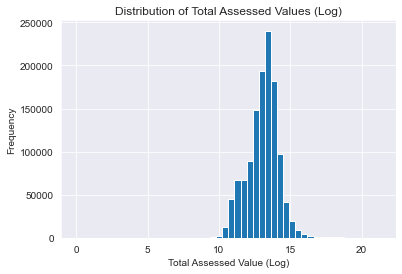

In [69]:
# Take a look at Distribution of Log Total Assessed Values, normally distributed
plt.hist(df_encoded['Total Assessed Log Value'], bins=50)
plt.xlabel('Total Assessed Value (Log)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Assessed Values (Log)')
plt.show()

### 1e. Exporting Final Dataset

Since our source datasets are so large they cannot be uploaded to github, we will export the final dataset (`df_encoded`) that we have created here. That way, in the future, if you would like to run the model making cells below, you do not need to wait to download+clean the data in the above cells. Instead you can make use of the already cleaned and merged dataset.

In [70]:
df_encoded.to_csv('final_dataset.csv', index=False)

## 2. Baseline Model (Linear Regression and Median)

*Note: All of our models might underestimate valuations in comparison to how much a property might really sell for since increase in property tax valuations in California does not keep up with real-world inflation.*

### 2a. Prep/Split/Preprocessing

In [77]:
#Import the final dataset that we have created from `df_encoded`
df_encoded = pd.read_csv("final_dataset.csv")

In [78]:
# Check for nan values
df_encoded.isna().sum()

df_encoded = df_encoded.dropna()
df_encoded.columns

# Log of Total Assessed Value
df_encoded['Log of Total Assessed Value'] = np.log(df_encoded['Total Assessed Value'])

In [79]:
# train_test_validation split
X = df_encoded[['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units', 
       'Incident Counts', 'safe_day', 'safe_night', 'household_size',
       'cleanliness', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105',
       'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110',
       'Zipcode_94111', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115',
       'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121',
       'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127',
       'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134',
       'Zipcode_94158']]
Y = df_encoded['Log of Total Assessed Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = .2, random_state = 42)

### 2b. Model Definition/Run Model

In [80]:
# Model definition
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [81]:
# Construct dataframe of each feature & the corresponding coefficients
feature = ['Year', 'Assessed Personal Property Value', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units', 
       'Incident Counts', 'safe_day', 'safe_night', 'household_size',
       'cleanliness', 'Zipcode_94103', 'Zipcode_94104', 'Zipcode_94105',
       'Zipcode_94107', 'Zipcode_94108', 'Zipcode_94109', 'Zipcode_94110',
       'Zipcode_94111', 'Zipcode_94112', 'Zipcode_94114', 'Zipcode_94115',
       'Zipcode_94116', 'Zipcode_94117', 'Zipcode_94118', 'Zipcode_94121',
       'Zipcode_94122', 'Zipcode_94123', 'Zipcode_94124', 'Zipcode_94127',
       'Zipcode_94131', 'Zipcode_94132', 'Zipcode_94133', 'Zipcode_94134',
       'Zipcode_94158']

pd.DataFrame(zip(feature, model.coef_), columns = ['feature', 'coefficients'])

# Note: Zipcode_94104 & few others have many commercial buildings / tech companies

,feature,coefficients
0,Year,5.421172e-02
1,Assessed Personal Property Value,8.686840e-08
2,Year Property Built,1.940502e-03
3,Number of Bathrooms,1.631399e-02
4,Number of Bedrooms,3.454478e-03
5,Number of Rooms,3.699205e-03
6,Number of Stories,3.774199e-03
7,Number of Units,1.478816e-03
8,Incident Counts,4.025303e-06
9,safe_day,1.757373e-02


In [82]:
# RMSE for validation and train datasets
Y_pred_val = model.predict(X_val)
Y_pred_train = model.predict(X_train)
mean_squared_error(np.exp(Y_val), np.exp(Y_pred_val))**(1/2), mean_squared_error(np.exp(Y_train), np.exp(Y_pred_train))**(1/2)

(308289496853.65686, 339933381451.52325)

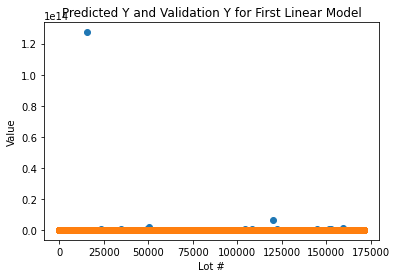

In [85]:
# Let's take a look
plt.scatter(np.arange(len(X_val)),np.exp(Y_pred_val)) #blue
plt.scatter(np.arange(len(X_val)),np.exp(Y_val)) #orange
plt.xlabel('Lot #')
plt.ylabel('Value')
plt.title("Predicted Y and Validation Y for First Linear Model")
plt.show()

**Model Tuning for Linear Regression**

In [84]:
# Narrow down features to the ones most correlated with Log of Total Assessed Value
df_encoded.corr().loc['Total Assessed Value'].sort_values(ascending=False)

Total Assessed Value                1.000000
Log of Total Assessed Value         0.269193
Total Assessed Log Value            0.269193
Number of Rooms                     0.194629
Number of Bathrooms                 0.192986
Number of Units                     0.177808
Assessed Personal Property Value    0.128839
Zipcode_94104                       0.106163
Number of Stories                   0.069979
Zipcode_94105                       0.059128
Zipcode_94111                       0.056280
Zipcode_94108                       0.032582
Assessor Neighborhood District      0.032440
Year Property Built                 0.025765
Zipcode_94103                       0.019072
Year                                0.018321
Number of Bedrooms                  0.018146
Zipcode_94158                       0.016659
Zipcode_94123                       0.011384
Zipcode_94115                       0.008344
Zipcode_94133                       0.006563
Incident Counts                     0.006562
Zipcode_94

In [41]:
# Take all features with >0.05 or <-0.05 coefficient & redo train-test split

# train_test_validation split
X = df_encoded[['Number of Bathrooms', 'Number of Rooms', 'Zipcode_94123','Number of Units','Zipcode_94105','Zipcode_94124','household_size'                    
,'Zipcode_94112','Zipcode_94134','Zipcode_94122','Zipcode_94116','cleanliness','Year','Year Property Built','Zipcode_94104'                       
,'Zipcode_94115','Number of Bedrooms','Zipcode_94109','Zipcode_94111','Number of Stories','Zipcode_94114','Zipcode_94103'                     
,'Zipcode_94108','safe_day']]
Y = df_encoded['Log of Total Assessed Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = .2, random_state = 42)

In [42]:
# Model Definition
model2 = LinearRegression()
model2.fit(X_train, Y_train)

LinearRegression()

In [43]:
feature2 = ['Number of Bathrooms', 'Number of Rooms', 'Zipcode_94123','Number of Units','Zipcode_94105','Zipcode_94124','household_size'                    
,'Zipcode_94112','Zipcode_94134','Zipcode_94122','Zipcode_94116','cleanliness','Year','Year Property Built','Zipcode_94104'                       
,'Zipcode_94115','Number of Bedrooms','Zipcode_94109','Zipcode_94111','Number of Stories','Zipcode_94114','Zipcode_94103'                     
,'Zipcode_94108','safe_day']

# Construct dataframe of each feature & the corresponding coefficients
pd.DataFrame(zip(feature, model2.coef_), columns = ['feature', 'coefficients'])

,feature,coefficients
0,Year,0.016979
1,Assessed Personal Property Value,0.003768
2,Year Property Built,0.497039
3,Number of Bathrooms,0.001362
4,Number of Bedrooms,0.463105
5,Number of Rooms,-0.547121
6,Number of Stories,-0.090169
7,Number of Units,-0.504120
8,Incident Counts,-0.518680
9,safe_day,-0.246847


In [44]:
# RMSE for validation and train datasets
Y_pred_val = model2.predict(X_val)
Y_pred_train = model2.predict(X_train)
mean_squared_error(np.exp(Y_val), np.exp(Y_pred_val))**(1/2), mean_squared_error(np.exp(Y_train), np.exp(Y_pred_train))**(1/2)

(2327556402407.6025, 1956512374110.6477)

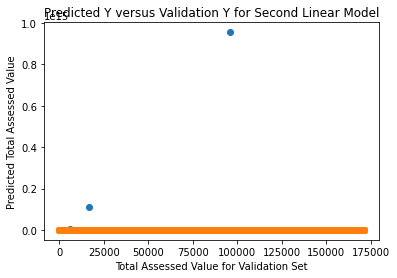

In [48]:
# Let's take a look
plt.scatter(np.arange(len(X_val)),np.exp(Y_pred_val))
plt.scatter(np.arange(len(X_val)),np.exp(Y_val))
plt.xlabel('Total Assessed Value for Validation Set')
plt.ylabel('Predicted Total Assessed Value')
plt.title("Predicted Y versus Validation Y for Second Linear Model")
plt.show()

In [84]:
# Test Result for Final Linear Model:
# Evaluate the model
Y_predlinear =model2.predict(X_test)
mean_squared_error(np.exp(Y_test), np.exp(Y_predlinear))**(1/2)

252689331870.59195

**Given that our linear models performed really poorly, we decided to change the baseline model to the median**

In [46]:
# RMSE for validation and train datasets
model3 = np.median(Y_train)
Y_pred3 = np.full(len(Y_val), model3)
Y_predtrain = np.full(len(Y_train), model3)
(mean_squared_error(np.exp(Y_val), np.exp(Y_pred3))**(1/2), mean_squared_error(np.exp(Y_train), np.exp(Y_predtrain))**(1/2))

(4713523.811974167, 4703213.630206855)

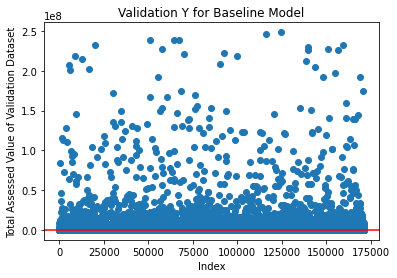

In [47]:
# Let's take a look
plt.scatter(np.arange(len(X_val)),np.exp(Y_val))
plt.xlabel('Index')
plt.ylabel('Total Assessed Value of Validation Dataset')
plt.axhline(model3, color = 'red')
plt.title("Validation Y for Baseline Model")
plt.show()
# Note: the line is the our baseline prediction 

In [87]:
#Test Result for Median Model:
# Evaluate the model
Y_predmedian = np.full(len(Y_test), model3)
mean_squared_error(np.exp(Y_test), np.exp(Y_predmedian))**(1/2)

7221440.689138853

## 3. Final Model (Random Forest)

### 3a. Prep/Split/Preprocessing

***Remove data points with valuation above 500 million to avoid outliers, and also log features & response***

In [93]:
#safe_day, safe_night, cleanliness --> convert these to binary (<3 not safe/clean, >= 3 safe/clean)
df_encoded['safe_day_binary'] = np.where(df_encoded['safe_day']<3, 0, 1)
df_encoded['safe_night_binary'] = np.where(df_encoded['safe_night']<3, 0, 1)
df_encoded['cleanliness_binary'] = np.where(df_encoded['cleanliness']<3, 0, 1)

In [94]:
# Filter for 'Total Assessed Value' < 250000000
df_new = df_encoded[df_encoded['Total Assessed Value'] < 250000000]

# Take all features with >0.05 or <-0.05 coefficient & redo train-test-validation split
X = df_new[['Number of Bathrooms', 'Number of Rooms', 'Zipcode_94123','Number of Units','Zipcode_94105','Zipcode_94124','household_size'                    
,'Zipcode_94112','Zipcode_94134','Zipcode_94122','Zipcode_94116','cleanliness','Year','Year Property Built','Zipcode_94104'                       
,'Zipcode_94115','Number of Bedrooms','Zipcode_94109','Zipcode_94111','Number of Stories','Zipcode_94114','Zipcode_94103'                     
,'Zipcode_94108','safe_day_binary']]
Y = df_new['Log of Total Assessed Value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = .2, random_state = 42)

### 3b. Model Definition/Run Model

In [9]:
# Define Model
rf = RandomForestRegressor(n_estimators=10, random_state=42)  
rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [11]:
# Make predictions on validation
Y_pred1 = rf.predict(X_val)

# Evaluate the model
Y_pred_val = rf.predict(X_val)
Y_pred_train = rf.predict(X_train)
mean_squared_error(np.exp(Y_val), np.exp(Y_pred_val))**(1/2), mean_squared_error(np.exp(Y_train), np.exp(Y_pred_train))**(1/2)

(2199539.0445950455, 1370849.9003143772)

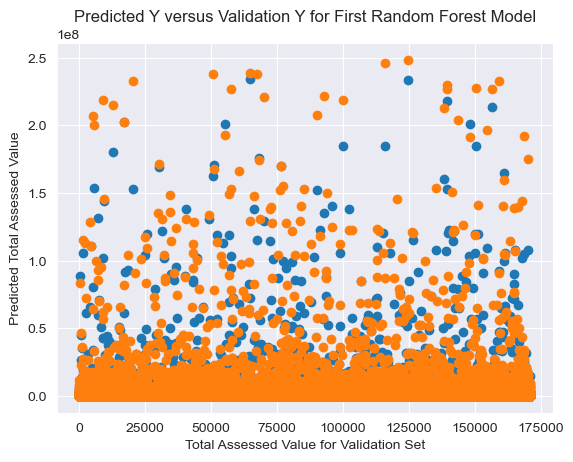

In [84]:
# Let's take a look
plt.scatter(np.arange(len(X_val)),np.exp(Y_pred1))
plt.scatter(np.arange(len(X_val)),np.exp(Y_val))
plt.xlabel('Total Assessed Value for Validation Set')
plt.ylabel('Predicted Total Assessed Value')
plt.title("Predicted Y versus Validation Y for First Random Forest Model")
plt.show()

In [95]:
# Increase n_estimators to 20
rf2 = RandomForestRegressor(n_estimators=20, random_state=42)  
rf2.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [96]:
# Make predictions on validation
Y_pred2 = rf2.predict(X_val)

# Evaluate the model
Y_pred_val =rf2.predict(X_val)
Y_pred_train = rf2.predict(X_train)
mean_squared_error(np.exp(Y_val), np.exp(Y_pred_val))**(1/2), mean_squared_error(np.exp(Y_train), np.exp(Y_pred_train))**(1/2)

(2127457.2478843774, 1313411.4599670158)

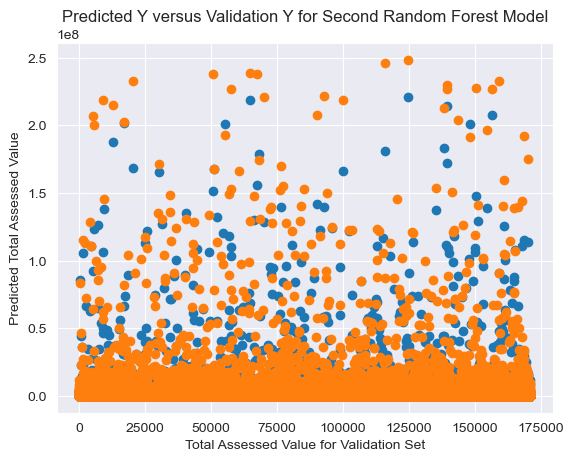

In [87]:
# Let's take another look
plt.scatter(np.arange(len(X_val)),np.exp(Y_pred2))
plt.scatter(np.arange(len(X_val)),np.exp(Y_val))
plt.xlabel('Total Assessed Value for Validation Set')
plt.ylabel('Predicted Total Assessed Value')
plt.title("Predicted Y versus Validation Y for Second Random Forest Model")
plt.show()

In [88]:
#Test Result for Final Model:
# Evaluate the model
Y_predfinal =rf2.predict(X_test)
mean_squared_error(np.exp(Y_test), np.exp(Y_predfinal))**(1/2)

2107751.893084619

### Because of how computationally expensive tuning the random forest models is, we will do this in two batches (n_trees = 1-->19, and n_trees = 20 ->30)

In [24]:
#Define a list of values for n_tree
n_tree_values2 = list(range(1, 20))

# Create empty lists to store the RMSE for training and validation sets
train_rmse2 = []
val_rmse2 = []
pred_train2 = []
pred_val2 = []

# Iterate over the values of n_tree
for n_tree in n_tree_values2:
    # Create a random forest model with n_tree trees
    model = RandomForestRegressor(n_estimators=n_tree, random_state=42)

    # Fit the model to the training data
    model.fit(X_train, Y_train)

    # Calculate the mean squared error of the model on the training data
    y_train_pred = model.predict(X_train)
    pred_train2.append(y_train_pred)
    train_mse = mean_squared_error(np.exp(Y_train), np.exp(y_train_pred))
    train_rmse2.append(np.sqrt(train_mse))

    # Calculate the mean squared error of the model on the validation data
    y_val_pred = model.predict(X_val)
    pred_val2.append(y_val_pred)
    val_mse = mean_squared_error(np.exp(Y_val), np.exp(y_val_pred))
    val_rmse2.append(np.sqrt(val_mse))

    # Print the training and validation RMSE and the value of n_tree
    print(f"Training RMSE with {n_tree} trees: {train_rmse2[-1]}")
    print(f"Validation RMSE with {n_tree} trees: {val_rmse2[-1]}")

Training RMSE with 1 trees: 2009064.2313023033
Validation RMSE with 1 trees: 3067050.9288250795
Training RMSE with 2 trees: 1562846.8927714643
Validation RMSE with 2 trees: 2481057.36624303
Training RMSE with 3 trees: 1466277.7768563312
Validation RMSE with 3 trees: 2355926.524769733
Training RMSE with 4 trees: 1387887.8897689239
Validation RMSE with 4 trees: 2266145.0860170242
Training RMSE with 5 trees: 1394963.0695576218
Validation RMSE with 5 trees: 2233794.3528246866
Training RMSE with 6 trees: 1418224.65940729
Validation RMSE with 6 trees: 2264702.8521500477
Training RMSE with 7 trees: 1397916.0915324797
Validation RMSE with 7 trees: 2263864.7872152934
Training RMSE with 8 trees: 1392009.4307936865
Validation RMSE with 8 trees: 2248845.4498981247
Training RMSE with 9 trees: 1382416.2120296226
Validation RMSE with 9 trees: 2203599.0546612963
Training RMSE with 10 trees: 1370849.9003143772
Validation RMSE with 10 trees: 2199539.0445950455
Training RMSE with 11 trees: 1363648.507401

In [29]:
#Display results as a dataframe
rf_df = pd.DataFrame({'N Trees': n_tree_values2,
    'Training RMSE': train_rmse2,
    'Validation RMSE': val_rmse2})
rf_df

,N Trees,Training RMSE,Validation RMSE
0,1,2.009064e+06,3.067051e+06
1,2,1.562847e+06,2.481057e+06
2,3,1.466278e+06,2.355927e+06
3,4,1.387888e+06,2.266145e+06
4,5,1.394963e+06,2.233794e+06
5,6,1.418225e+06,2.264703e+06
6,7,1.397916e+06,2.263865e+06
7,8,1.392009e+06,2.248845e+06
8,9,1.382416e+06,2.203599e+06
9,10,1.370850e+06,2.199539e+06


In [98]:
#repeat the same process as above but for 20-30 trees

# Define a list of values for n_tree
n_tree_values = list(range(20, 31))

# Create empty lists to store the RMSE for training and validation sets
train_rmse = []
val_rmse = []
pred_train = []
pred_val = []

# Iterate over the values of n_tree
for n_tree in n_tree_values:
    # Create a random forest model with n_tree trees
    model = RandomForestRegressor(n_estimators=n_tree, random_state=42)

    # Fit the model to the training data
    model.fit(X_train, Y_train)

    # Calculate the mean squared error of the model on the training data
    y_train_pred = model.predict(X_train)
    pred_train.append(y_train_pred)
    train_mse = mean_squared_error(np.exp(Y_train), np.exp(y_train_pred))
    train_rmse.append(np.sqrt(train_mse))

    # Calculate the mean squared error of the model on the validation data
    y_val_pred = model.predict(X_val)
    pred_val.append(y_val_pred)
    val_mse = mean_squared_error(np.exp(Y_val), np.exp(y_val_pred))
    val_rmse.append(np.sqrt(val_mse))

    # Print the training and validation RMSE and the value of n_tree
    print(f"Training RMSE with {n_tree} trees: {train_rmse[-1]}")
    print(f"Validation RMSE with {n_tree} trees: {val_rmse[-1]}")


Training RMSE with 20 trees: 1313411.4599670158
Validation RMSE with 20 trees: 2127457.2478843774
Training RMSE with 21 trees: 1307315.6269022988
Validation RMSE with 21 trees: 2111001.5775037375
Training RMSE with 22 trees: 1304084.2324692311
Validation RMSE with 22 trees: 2111730.7639145455
Training RMSE with 23 trees: 1300370.7287726142
Validation RMSE with 23 trees: 2104905.834008834
Training RMSE with 24 trees: 1306114.6915018002
Validation RMSE with 24 trees: 2098377.2822846826
Training RMSE with 25 trees: 1311707.081629981
Validation RMSE with 25 trees: 2104352.358500697
Training RMSE with 26 trees: 1304670.949990288
Validation RMSE with 26 trees: 2094889.967909521
Training RMSE with 27 trees: 1305387.0429771207
Validation RMSE with 27 trees: 2099007.4213306806
Training RMSE with 28 trees: 1299872.0700573036
Validation RMSE with 28 trees: 2096112.859226723
Training RMSE with 29 trees: 1299613.3396722828
Validation RMSE with 29 trees: 2101701.9667095696
Training RMSE with 30 tree

In [99]:
#Display results as a dataframe
rf_df = pd.DataFrame({'N Trees': n_tree_values,
    'Training RMSE': train_rmse,
    'Validation RMSE': val_rmse})

In [100]:
rf_df

,N Trees,Training RMSE,Validation RMSE
0,20,1.313411e+06,2.127457e+06
1,21,1.307316e+06,2.111002e+06
2,22,1.304084e+06,2.111731e+06
3,23,1.300371e+06,2.104906e+06
4,24,1.306115e+06,2.098377e+06
5,25,1.311707e+06,2.104352e+06
6,26,1.304671e+06,2.094890e+06
7,27,1.305387e+06,2.099007e+06
8,28,1.299872e+06,2.096113e+06
9,29,1.299613e+06,2.101702e+06


In [101]:
#combien all rmse to one df
final_rfdf = pd.concat([rf_df2, rf_df])
final_rfdf

,N Trees,Training RMSE,Validation RMSE
0,1,2.009064e+06,3.067051e+06
1,2,1.562847e+06,2.481057e+06
2,3,1.466278e+06,2.355927e+06
3,4,1.387888e+06,2.266145e+06
4,5,1.394963e+06,2.233794e+06
5,6,1.418225e+06,2.264703e+06
6,7,1.397916e+06,2.263865e+06
7,8,1.392009e+06,2.248845e+06
8,9,1.382416e+06,2.203599e+06
9,10,1.370850e+06,2.199539e+06


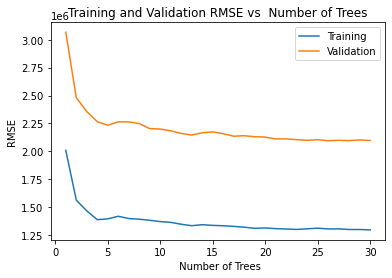

In [102]:
plt.plot(final_rfdf['N Trees'], final_rfdf['Training RMSE'], label='Training')
plt.plot(final_rfdf['N Trees'], final_rfdf['Validation RMSE'], label='Validation')
plt.title('Training and Validation RMSE vs  Number of Trees')
plt.xlabel(' Number of Trees')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### At around 20 trees we see the graph flatten out and so we select this value. Though there is overfitting we do not see divergence in the values.

In [118]:
#get test RMSE
final_rf = RandomForestRegressor(n_estimators=20, random_state=42)  
final_rf.fit(X_train, Y_train)

# Make predictions on test
Y_pred_test = final_rf.predict(X_test)
# Evaluate the model
final_test_rmse = mean_squared_error(np.exp(Y_test), np.exp(Y_pred_test))**(1/2)
final_test_rmse

2107751.893084619

### We also want to tune the max_depth as we observe overfitting, since this is computationally expensive, we can first try depths of 1 to 9

In [120]:
#we want to reduce overfitting, so want to lower complexity

# Define a list of values for max_depth (let's take 30 as our max number as max depth)
max_depth_values = list(range(1, 10))

# Create empty lists to store the RMSE for training and validation sets
train_rmse4 = []
val_rmse4 = []
pred_train4 = []
pred_val4 = []

# Iterate over the values of n_tree
for max_depths in max_depth_values:
    # Create a random forest model with n_tree trees
    model = RandomForestRegressor(n_estimators=20, random_state=42, max_depth=max_depths)

    # Fit the model to the training data
    model.fit(X_train, Y_train)

    # Calculate the mean squared error of the model on the training data
    y_train_pred4 = model.predict(X_train)
    pred_train.append(y_train_pred4)
    train_mse = mean_squared_error(np.exp(Y_train), np.exp(y_train_pred4))
    train_rmse4.append(np.sqrt(train_mse))

    # Calculate the mean squared error of the model on the validation data
    y_val_pred4 = model.predict(X_val)
    pred_val.append(y_val_pred4)
    val_mse = mean_squared_error(np.exp(Y_val), np.exp(y_val_pred4))
    val_rmse4.append(np.sqrt(val_mse))

    # Print the training and validation RMSE and the value of n_tree
    print(f"Training RMSE with max depth of {max_depths}: {train_rmse4[-1]}")
    print(f"Validation RMSE with max depth of {max_depths} : {val_rmse4[-1]}")


Training RMSE with max depth of 1: 4693923.2920727255
Validation RMSE with max depth of 1 : 4704449.7948438
Training RMSE with max depth of 2: 4654467.490457152
Validation RMSE with max depth of 2 : 4667177.63822036
Training RMSE with max depth of 3: 4600769.127543059
Validation RMSE with max depth of 3 : 4618774.209870736
Training RMSE with max depth of 4: 4399324.86929937
Validation RMSE with max depth of 4 : 4413561.168685507
Training RMSE with max depth of 5: 3956519.9987624325
Validation RMSE with max depth of 5 : 3910039.03904838
Training RMSE with max depth of 6: 3778020.1637200587
Validation RMSE with max depth of 6 : 3717020.41824864
Training RMSE with max depth of 7: 3566133.267823827
Validation RMSE with max depth of 7 : 3500725.6154934065
Training RMSE with max depth of 8: 3315856.242474578
Validation RMSE with max depth of 8 : 3291628.1310406164
Training RMSE with max depth of 9: 3050897.0631376184
Validation RMSE with max depth of 9 : 3062035.804503866


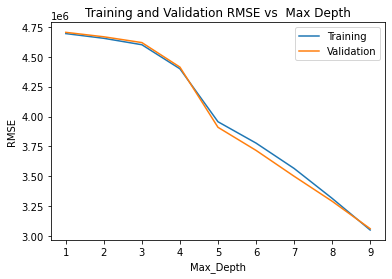

In [122]:
plt.plot(max_depth_values, train_rmse4, label='Training')
plt.plot(max_depth_values, val_rmse4, label='Validation')
plt.title('Training and Validation RMSE vs  Max Depth')
plt.xlabel('Max_Depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### Seeing that tuning max depth is still resulting in similar overfitting issues, even when running the lowest depths possible, we can stop here in the tuning. We can see that there is some crossover around max depth of 4, but the results RMSE is significantly higher than what we observed when allowing for the larger max_depth. We decided to compromise on overfitting to achieve a lower RMSE, since we did not observe any divergence in the validation and training RMSE

### 3c. Model Results

Please see below for our model results

| Model | Train RMSE|  Validation RMSE|  Test RMSE for Tuned Model |
|:-:                |:-:                  |:-:           |:-:        |
| First Linear Model             |   339933381452.719         |  308289496854.8      | N/A      |
| Second Linear Model             |  246863620528.9301      |    254280097924.99942      | 168664180981.5098      |
| Baseline Model (Median)           | 4703213.630206855| 4713523.811974167    | 4406240.195313015    |
| First Random Forest (n_tree = 10)          |1370849.9003143772 | 2199539.0445950455  | N/A   |
| Last Random Forest (n_tree = 20) (Final)         |1296022.1832904606 | 2097233.254054204 | 2107751.893084619|


